In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import os
from os import listdir

from scipy import signal

from comms import *

In [2]:
class preamble_detector(nn.Module):
    def __init__(self):
        super(preamble_detector, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, (2,35), 1, padding=(0,17),bias=False)
        self.conv2 = nn.Conv2d(16, 16, (1,35), 1, padding=(0,17), bias=False)
        self.conv3 = nn.Conv2d(16, 1, (1,1), 1, padding=(0,0), bias=False)

    def forward(self, x):

        # Do cross correlation
        x = F.relu(self.conv1(x))
        out1 = x
        
        # Sum real and imag
        x = F.relu(self.conv2(x))
        out2 = x
        
        x= self.conv3(x)
        
        # Output only 1 dimension
        x = x.squeeze()

        return x#, out1, out2

In [3]:
test_detector = preamble_detector()
test_detector.load_state_dict(torch.load('models/insight_model.pt'))

<All keys matched successfully>

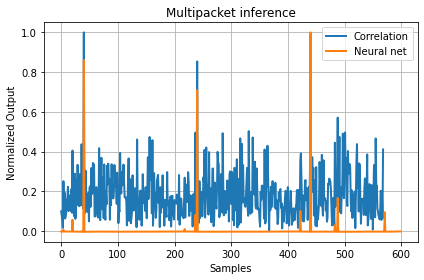

In [4]:
preamble_seq = signal.max_len_seq(6)[0][:32]
preamble = np.where(preamble_seq < 1, -1+0j, 1+0j)
waveform1 = awgn(create_frame(preamble_seq, signal_length=200, offset=40),0)
waveform2 = awgn(create_frame(preamble_seq, signal_length=200, offset=40),0)
waveform3 = awgn(create_frame(preamble_seq, signal_length=200, offset=40),0)

waveform = np.concatenate((waveform1, waveform2, waveform3))

my_frame = torch.FloatTensor(np.expand_dims(np.vstack((waveform.real, waveform.imag)),axis=(0,1)))

y = test_detector(my_frame)
correlation = np.abs(np.correlate(waveform, preamble, mode='valid'))
plt.plot(correlation/np.max(correlation), linewidth=2)
plt.plot((y/torch.max(y)).detach().numpy(), linewidth=2)
plt.legend(('Correlation','Neural net'))
plt.grid()
plt.title('Multipacket inference')
plt.ylabel('Normalized Output'); plt.xlabel('Samples')
plt.tight_layout()
# plt.savefig('figures/multipacket.png', dpi=300, bbox_inches='tight')

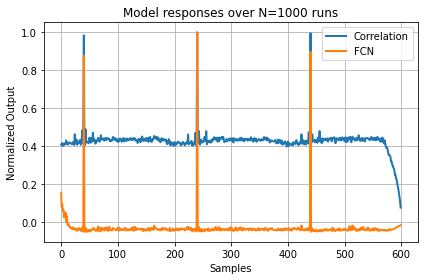

In [5]:
num_iter = 1000

signal_length = 600
snr = -10
tau = 120

front_pad = 32

nn_outputs = np.zeros((num_iter,signal_length))
corr_outputs = np.zeros((num_iter,signal_length))#-len(preamble_seq)+1))

for i in range(num_iter):
    waveform1 = awgn(create_frame(preamble_seq, signal_length=200, offset=40), snr)
    waveform2 = awgn(create_frame(preamble_seq, signal_length=200, offset=40), snr)
    waveform3 = awgn(create_frame(preamble_seq, signal_length=200, offset=40), snr)

    waveform = np.concatenate((waveform1, waveform2, waveform3))

    my_frame = torch.FloatTensor(np.expand_dims(np.vstack((waveform.real, waveform.imag)),axis=(0,1)))

    nn_outputs[i,:] = test_detector(my_frame).detach().numpy()
    corr_outputs[i,:] = np.abs(np.correlate(waveform, preamble, mode='full')[len(preamble)-1:])
    
y_nn = nn_outputs.mean(axis=0)
y_corr = corr_outputs.mean(axis=0)

plt.plot(y_corr/np.max(y_corr), linewidth=2)
plt.plot(y_nn/np.max(y_nn), linewidth=2)
plt.grid()
plt.legend(('Correlation', 'FCN'))
plt.title('Model responses over N=1000 runs')
plt.ylabel('Normalized Output'); plt.xlabel('Samples')
plt.tight_layout()
# plt.savefig('figures/fcn_multipacket.png', dpi=300, bbox_inches='tight')

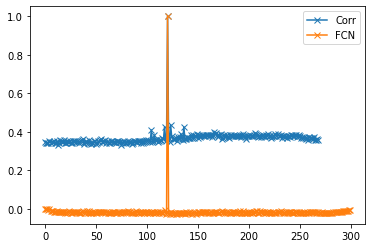

In [6]:
num_iter = 1000

signal_length = 300
snr = -10
tau = 120

front_pad = 32

nn_outputs = np.zeros((num_iter,signal_length))
corr_outputs = np.zeros((num_iter,signal_length-len(preamble_seq)+1))

for i in range(num_iter):
    waveform = awgn(create_frame(preamble_seq, signal_length=signal_length, offset=tau),snr)
    nn_waveform = np.concatenate((np.zeros(front_pad,),waveform))
    my_frame = torch.FloatTensor(np.expand_dims(np.vstack((nn_waveform.real, nn_waveform.imag)),axis=(0,1)))

    nn_outputs[i,:] = test_detector(my_frame).detach().numpy()[front_pad:]
    corr_outputs[i,:] = np.abs(np.correlate(waveform, preamble, mode='valid'))
    
y_nn = nn_outputs.mean(axis=0)
y_corr = corr_outputs.mean(axis=0)

plt.plot(y_corr/np.max(y_corr),'-x')
plt.plot(y_nn/np.max(y_nn),'-x')
plt.legend(('Corr', 'FCN'))

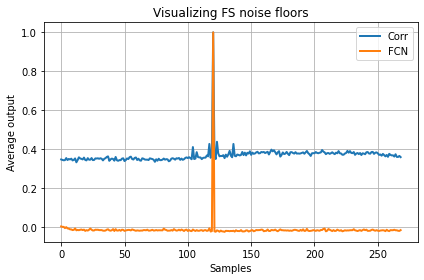

In [7]:
plt.plot(y_corr/np.max(y_corr),'-', linewidth=2)
plt.plot(y_nn[:len(y_corr)]/np.max(y_nn),'-', linewidth=2)
plt.legend(('Corr', 'FCN'))
plt.xlabel('Samples'); plt.ylabel('Average output')
plt.title('Visualizing FS noise floors')
plt.grid()
plt.tight_layout()
# plt.savefig('figures/noisefloor.png', pdi=300)

In [8]:
class preamble_detector(nn.Module):
    def __init__(self):
        super(preamble_detector, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, (2,35), 1, padding=(0,17),bias=False)
        self.conv2 = nn.Conv2d(16, 16, (1,35), 1, padding=(0,17), bias=False)
        self.conv3 = nn.Conv2d(16, 1, (1,1), 1, padding=(0,0), bias=False)

    def forward(self, x):

        # Do cross correlation
        x = F.relu(self.conv1(x))
        out1 = x
        
        # Sum real and imag
        x = F.relu(self.conv2(x))
        out2 = x
        
        x= self.conv3(x)
        
        # Output only 1 dimension
        x = x.squeeze()

        return x, out1, out2

In [9]:
test_detector = preamble_detector()
test_detector.load_state_dict(torch.load('models/insight_model.pt'))

<All keys matched successfully>

In [16]:
preamble_seq = signal.max_len_seq(6)[0][:32]
preamble = np.where(preamble_seq < 1, -1+0j, 1+0j)
waveform = awgn(create_frame(preamble_seq, signal_length=200),0)
my_frame = torch.FloatTensor(np.expand_dims(np.vstack((waveform.real, waveform.imag)),axis=(0,1)))

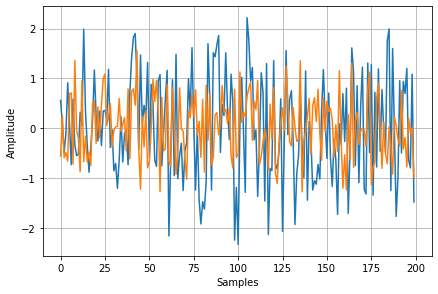

In [17]:
plt.plot(waveform.real)
plt.plot(waveform.imag)
# plt.plot(40,2, 'rx')
plt.grid()
# plt.title('Input waveform')
plt.tight_layout()
plt.xlabel('Samples'); plt.ylabel('Amplitude')
plt.savefig('figures/fcn_layer1_input.png', dpi=300, bbox_inches='tight')

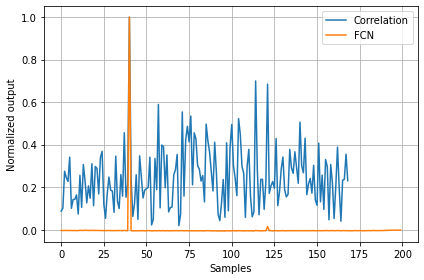

In [19]:
y,_,_ = test_detector(my_frame)
correlation = np.abs(np.correlate(waveform, preamble, mode='valid'))
plt.plot(correlation/np.max(correlation))
plt.plot((y/torch.max(y)).detach().numpy())
plt.legend(('Correlation','FCN'))
plt.xlabel('Samples'); plt.ylabel('Normalized output')
plt.grid()
plt.tight_layout()
plt.savefig('figures/fcn_layer3_output.png', dpi=300, bbox_inches='tight')

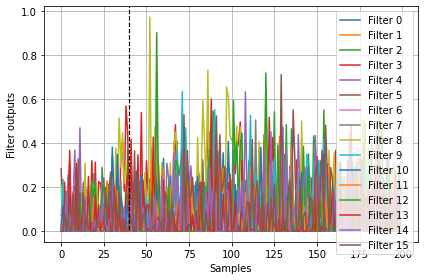

In [21]:
y, out1, out2 = test_detector(my_frame)
interm_output = out1.squeeze().detach().numpy().T
plt.plot(interm_output[:,0:16])
plt.axvline(x = 40, color = 'k', ymin=0.05, linestyle='--', linewidth=1.2)
# plt.ylim([0,1.1])
plt.grid()
plt.xlabel('Samples'); plt.ylabel('Filter outputs')
plt.tight_layout()
plt.legend([f'Filter {i}' for i in np.arange(16)])
plt.savefig('figures/fcn_layer1_outputs.png', dpi=300, bbox_inches='tight')

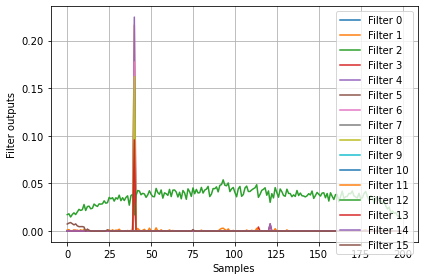

In [24]:
y, out1, out2 = test_detector(my_frame)
interm_output = out2.squeeze().detach().numpy().T
plt.plot(interm_output[:,:16])
# plt.axvline(x = 40, color = 'k', ymin=0, linestyle='--')#, linewidth=1.2)
plt.grid()
plt.xlabel('Samples'); plt.ylabel('Filter outputs')
plt.tight_layout()
# plt.ylim([0,1.1])
plt.legend([f'Filter {i}' for i in np.arange(16)])
plt.savefig('figures/fcn_layer2_outputs.png', dpi=300, bbox_inches='tight')

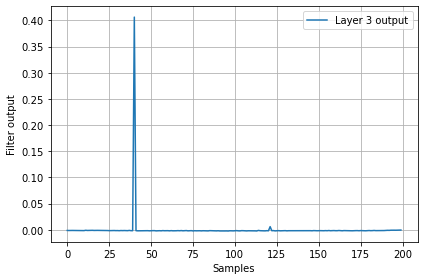

In [26]:
y, out1, out2 = test_detector(my_frame)
interm_output = out2.squeeze().detach().numpy().T
plt.plot(y.detach().numpy())
plt.grid()
# plt.ylim([0,1.1])
plt.legend(['Layer 3 output'])
plt.xlabel('Samples'); plt.ylabel('Filter output')
plt.tight_layout()
plt.savefig('figures/fcn_layer3_outputs.png', dpi=300, bbox_inches='tight')

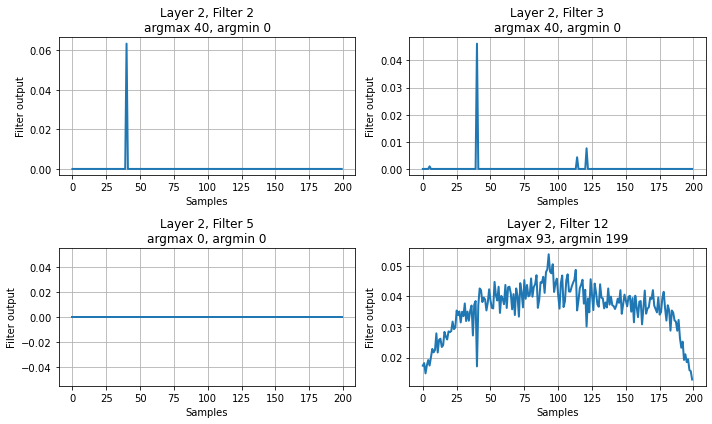

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(10,6))
interm_output = out2.squeeze().detach().numpy().T
j = 0
ax = ax.ravel()
for i in range(16):
    if i in [2, 3, 5, 12]:
        ax[j].plot(interm_output[:,i], linewidth=2)
        ax[j].set_title(f'Layer 2, Filter {i}\nargmax {np.argmax(interm_output[:,i])}, argmin {np.argmin(interm_output[:,i])}')
        ax[j].set_xlabel('Samples')
        ax[j].set_ylabel('Filter output')
        ax[j].grid()
        j+=1
plt.tight_layout()

# plt.savefig(f'figures/layer2_filter_outputs.png', dpi=300, bbox_inches='tight')

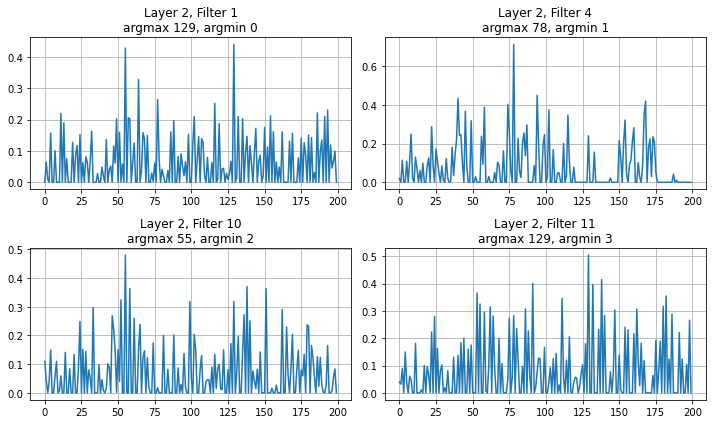

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(10,6))
interm_output = out1.squeeze().detach().numpy().T
j = 0
ax = ax.ravel()
for i in range(16):
    if i in [1, 4, 10, 11]:
        ax[j].plot(interm_output[:,i])
        ax[j].set_title(f'Layer 2, Filter {i}\nargmax {np.argmax(interm_output[:,i])}, argmin {np.argmin(interm_output[:,i])}')
        
        ax[j].grid()
        j+=1
plt.tight_layout()
# plt.savefig(f'figures/layer1_filter_outputs.png', dpi=300, bbox_inches='tight')

In [39]:
first_layer = test_detector.conv1.weight.detach().numpy()
second_layer = test_detector.conv2.weight.detach().numpy().squeeze()

In [41]:
for i in range(16):
    plt.figure()
    plt.plot(first_layer.squeeze()[i][0]/torch.max(first_layer.squeeze()[i][0]), linewidth=2)
#     plt.plot(first_layer.squeeze()[i][1], linewidth=2)
    plt.plot(np.arange(1,len(preamble)+1), preamble.real, 'r--', linewidth=2)
    plt.grid()
    plt.title(f'Filter {i}')
    plt.legend(['Learned weights', 'Preamble'], loc='lower right')
    plt.tight_layout()
    # plt.savefig('figures/filter_overlayed_with_preamble.png', dpi=300, bbox_inches='tight')

TypeError: max(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

<Figure size 432x288 with 0 Axes>

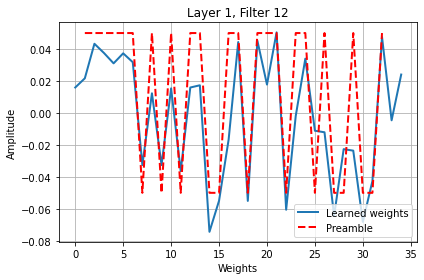

In [71]:
plt.plot(first_layer.squeeze()[12][0], linewidth=2)
plt.plot(np.arange(1,len(preamble)+1), preamble.real*0.05, 'r--', linewidth=2)
plt.grid()
plt.title('Layer 1, Filter 12')
plt.legend(['Learned weights', 'Preamble'], loc='lower right')
plt.xlabel('Weights')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.savefig('figures/filter_overlayed_with_preamble.png', dpi=300, bbox_inches='tight')

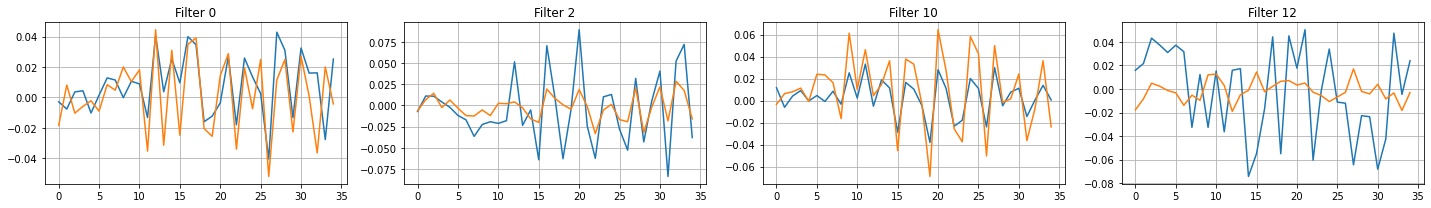

In [33]:
fig, ax = plt.subplots(1,4, figsize=(20,3))
ax[0].plot(first_layer.squeeze()[0][0])
ax[0].plot(first_layer.squeeze()[0][1])
ax[0].set_title('Filter 0')
ax[0].grid()
ax[1].plot(first_layer.squeeze()[2][0])
ax[1].plot(first_layer.squeeze()[2][1])
ax[1].set_title('Filter 2')
ax[1].grid()
ax[2].plot(first_layer.squeeze()[10][0])
ax[2].plot(first_layer.squeeze()[10][1])
ax[2].set_title('Filter 10')
ax[2].grid()
ax[3].plot(first_layer.squeeze()[12][0])
ax[3].plot(first_layer.squeeze()[12][1])
ax[3].set_title('Filter 12')
ax[3].grid()
plt.tight_layout()
# plt.savefig('figures/fcn_layer1_filters.png', dpi=300, bbox_inches='tight')

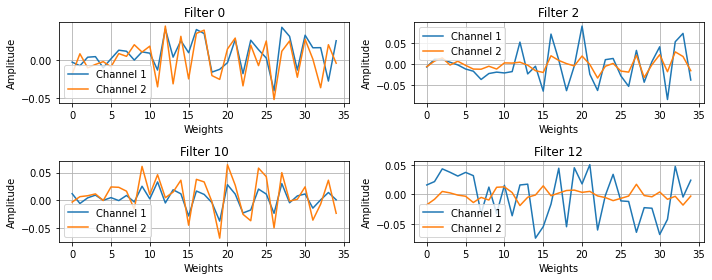

In [46]:
fig, ax = plt.subplots(2,2, figsize=(10,4))
ax[0,0].plot(first_layer.squeeze()[0][0])
ax[0,0].plot(first_layer.squeeze()[0][1])
ax[0,0].set_title('Filter 0')
ax[0,0].set_xlabel('Weights')
ax[0,0].set_ylabel('Amplitude')
ax[0,0].legend(['Channel 1', 'Channel 2'])
ax[0,0].grid()
ax[0,1].plot(first_layer.squeeze()[2][0])
ax[0,1].plot(first_layer.squeeze()[2][1])
ax[0,1].set_title('Filter 2')
ax[0,1].set_xlabel('Weights')
ax[0,1].set_ylabel('Amplitude')
ax[0,1].legend(['Channel 1', 'Channel 2'])
ax[0,1].grid()
ax[1,0].plot(first_layer.squeeze()[10][0])
ax[1,0].plot(first_layer.squeeze()[10][1])
ax[1,0].set_title('Filter 10')
ax[1,0].set_xlabel('Weights')
ax[1,0].set_ylabel('Amplitude')
ax[1,0].legend(['Channel 1', 'Channel 2'])
ax[1,0].grid()
ax[1,1].plot(first_layer.squeeze()[12][0])
ax[1,1].plot(first_layer.squeeze()[12][1])
ax[1,1].set_title('Filter 12')
ax[1,1].set_xlabel('Weights')
ax[1,1].set_ylabel('Amplitude')
ax[1,1].legend(['Channel 1', 'Channel 2'])
ax[1,1].grid()
plt.tight_layout()
plt.savefig('figures/fcn_layer1_filters.png', dpi=300, bbox_inches='tight')

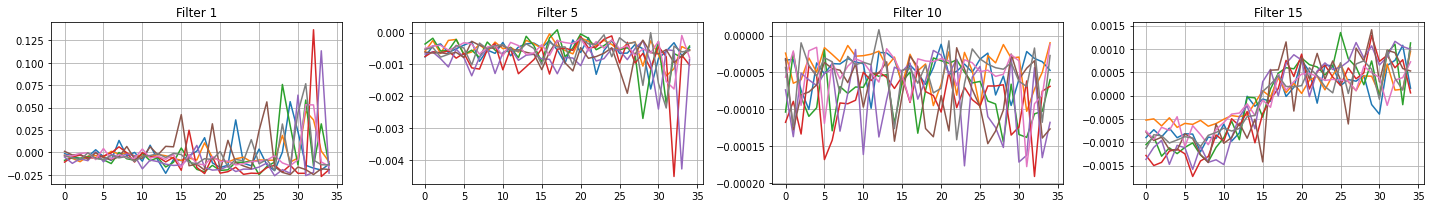

In [40]:
fig, ax = plt.subplots(1,4, figsize=(20,3))
j=0
for i in range(16):
#     ax[0,i].plot(preamble.real*0.05, 'k--')
    if i in [1,5,15,10]:
        ax[j].plot(second_layer[i][:8][:35].T)
        ax[j].set_title(f'Filter {i}')
        ax[j].grid()
        j+=1
plt.tight_layout()
# plt.savefig('figures/fcn_layer2_filters.png', dpi=300, bbox_inches='tight')

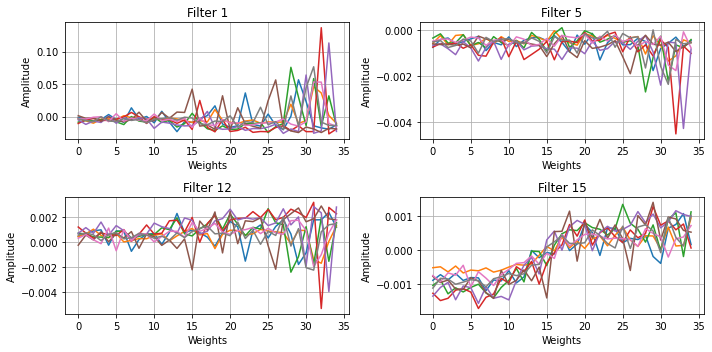

In [70]:
fig, ax = plt.subplots(2,2, figsize=(10,5))
ax = ax.ravel()
j=0
for i in range(16):
#     ax[0,i].plot(preamble.real*0.05, 'k--')
    if i in [1,5,15,12]:
        ax[j].plot(second_layer[i][:8][:35].T)
        ax[j].set_title(f'Filter {i}')
        ax[j].grid()
        ax[j].set_xlabel('Weights')
        ax[j].set_ylabel('Amplitude')
        j+=1
plt.tight_layout()
# plt.savefig('figures/fcn_layer2_filters.png', dpi=300, bbox_inches='tight')

In [32]:
# first_layer = a['conv1.weight']
first_layer = test_detector.state_dict()['conv1.weight']

In [33]:
first_layer.shape

torch.Size([16, 1, 2, 35])

In [148]:
def plot_filter(idx,first_layer):
    plt.plot(first_layer[idx][0][0][:])
    ax = plt.plot(first_layer[idx][0][1][:])
    return ax

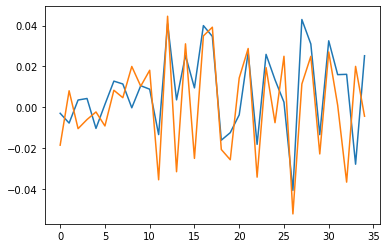

In [149]:
plot_filter(0,first_layer)

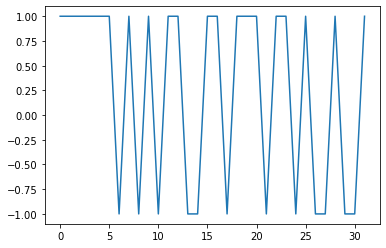

In [45]:
plt.plot(preamble.real)

In [46]:
def plot_filter(ax,first_layer,idx):
    ax.plot(first_layer[idx][0][0][:])
    ax.plot(first_layer[idx][0][1][:])
    return ax

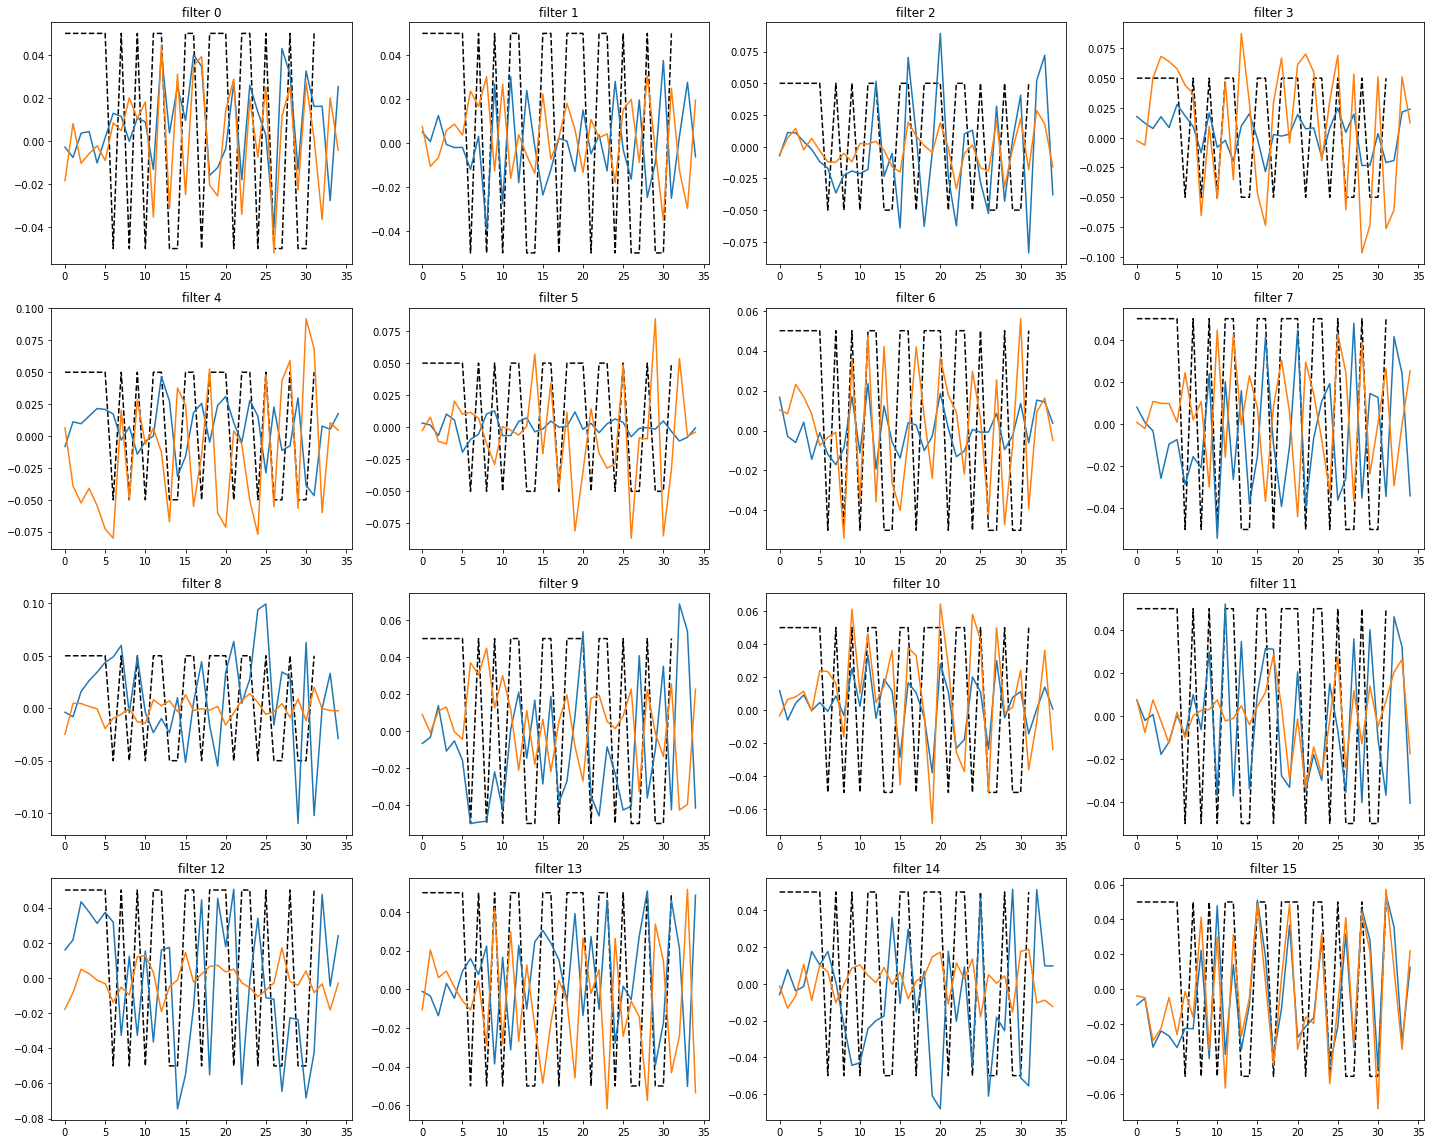

In [47]:
fig, ax = plt.subplots(4,4, figsize=(20,16))
for i in range(4):
    ax[0,i].plot(preamble.real*0.05, 'k--')
    plot_filter(ax[0,i],first_layer,i)
    ax[0,i].set_title(f'filter {i}')
for i in range(4):
    ax[1,i].plot(preamble.real*0.05, 'k--')
    plot_filter(ax[1,i],first_layer,i+4)
    ax[1,i].set_title(f'filter {i+4}')
for i in range(4):
    ax[2,i].plot(preamble.real*0.05, 'k--')
    plot_filter(ax[2,i],first_layer,i+8)
    ax[2,i].set_title(f'filter {i+8}')
for i in range(4):
    ax[3,i].plot(preamble.real*0.05, 'k--')
    plot_filter(ax[3,i],first_layer,i+12)
    ax[3,i].set_title(f'filter {i+12}')
plt.tight_layout()
# plt.title('First layer filters of FCN')
# plt.savefig('individual_filters.png', dpi=300)

In [49]:
second_layer = test_detector.state_dict()['conv2.weight']
second_layer = second_layer.squeeze()

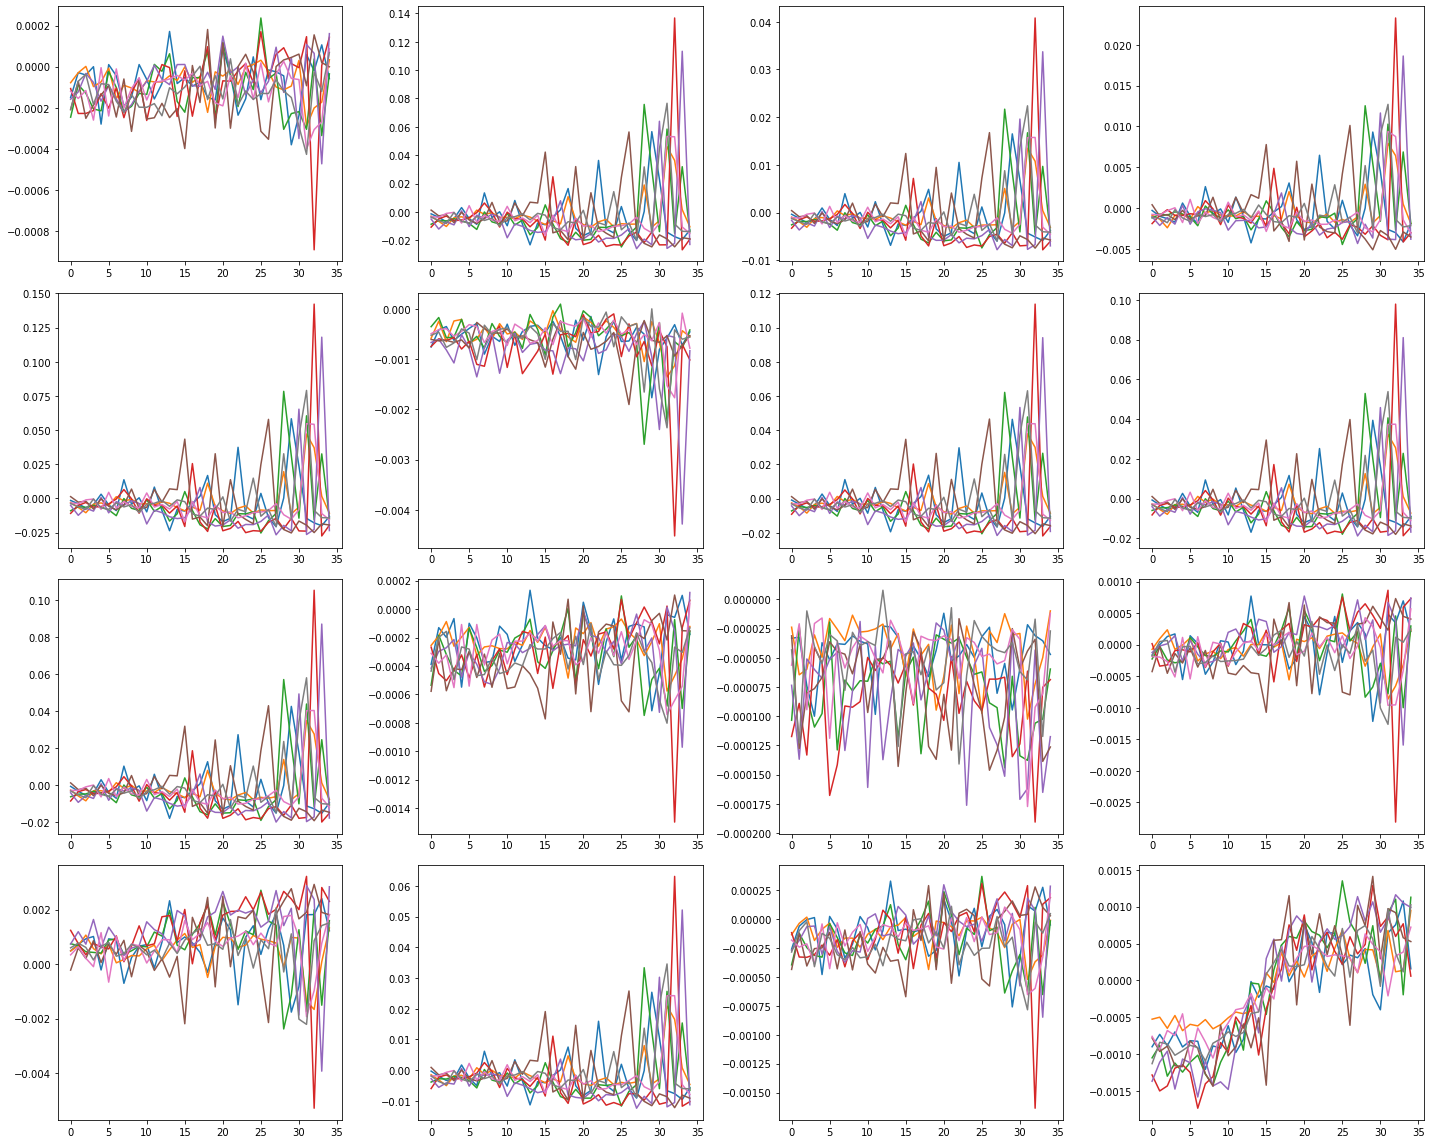

In [53]:
fig, ax = plt.subplots(4,4, figsize=(20,16))
for i in range(4):
#     ax[0,i].plot(preamble.real*0.05, 'k--')
    ax[0,i].plot(second_layer[i][:8][:35].T)
#     ax[0,i].plot(second_layer[i][0][:])
for i in range(4):
#     ax[1,i].plot(preamble.real*0.05, 'k--')
    ax[1,i].plot(second_layer[i+4][:8][:35].T)
#     ax[1,i].plot(second_layer[i+4][0][:])
for i in range(4):
#     ax[2,i].plot(preamble.real*0.05, 'k--')
    ax[2,i].plot(second_layer[i+8][:8][:35].T)
#     ax[2,i].plot(second_layer[i+8][0][:])
for i in range(4):
#     ax[3,i].plot(preamble.real*0.05, 'k--')
    ax[3,i].plot(second_layer[i+12][:8][:35].T)
#     ax[3,i].plot(second_layer[i+12][0][:])
plt.tight_layout()
# plt.title('First layer filters of FCN')
# plt.savefig('individual_filters.png', dpi=300)

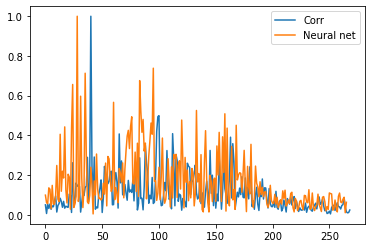

In [60]:
preamble_seq = signal.max_len_seq(6)[0][:32]
preamble = np.where(preamble_seq < 1, -1+0j, 1+0j)
waveform = awgn(create_frame(preamble_seq, signal_length=300),10)
# my_frame = torch.FloatTensor(np.expand_dims(np.vstack((waveform.real, waveform.imag)),axis=(0,1)))

single_filter = first_layer[0].squeeze()
single_filter = single_filter[0] #+single_filter[1]*1j

single_filter_output = np.abs(np.correlate(waveform, single_filter, mode='valid'))

# y = detector_32(my_frame)
correlation = np.abs(np.correlate(waveform, preamble, mode='valid'))
plt.plot(correlation/np.max(correlation))
plt.plot(single_filter_output/np.max(single_filter_output))
# plt.plot((y/torch.max(y)).detach().numpy())
plt.legend(('Corr','Neural net'))